### **Nano Project 4**
In this project compare Quasi Monte Carlo and Monte Carlo methods for pricing a European call option. More specifically we implement an adapted Box-Muller simulation basen on the Sobol sequence.
The Quasi Monte Carlo Box Muller method allows us to compute $Z\sim\mathcal{N}(0,I_d)$ with $d=2n$, $n\in\mathbb{N}$ for convenience, random variables by taking a uniformly distributed sequence $(\xi_n)_{n\geq 1}$ over $[0,1]^d$ and then plugging these into:
$$(\zeta^{2i-1}_n,\zeta^{2i}_n)=\left(\sqrt{-2\log(\xi^{2i-1}_n)}\cos(2\pi\xi^{2i}_n), \sqrt{-2\log(\xi^{2i-1}_n)}\sin(2\pi\xi^{2i}_n)\right)$$
To perform QMC we use the low-discrepancy Sobol sequence and compare to a regular MC computation. We recall the Black-Scholes model, within which we simulate the risky asset.
The simulated asset price at time $t$ is:
$
X_t^x = x e^{(r - \frac{1}{2} \sigma^2)t + \sigma \sqrt{t} Z}
$
where:
- $ X_t^x $ is the stock price at time t,
- $\sigma$ is the volatility,
- $ r $ is the risk free rate
Furthermore the payoff of a call option at maturity $T$ is given as
$$
Call_{BS} = \max(S_T - K, 0)
$$
where:
- $ K $ is the strike price
We start by simulating the underlying asset via the two methods and then computing the call price for the strike prices $K\in\{95, 96, ..., 104,105\}$. Hereafter we plot the average price of the options considered calculated over the number of simulations.

In [30]:
import numpy as np
import scipy.stats as stats
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
import seaborn as sns

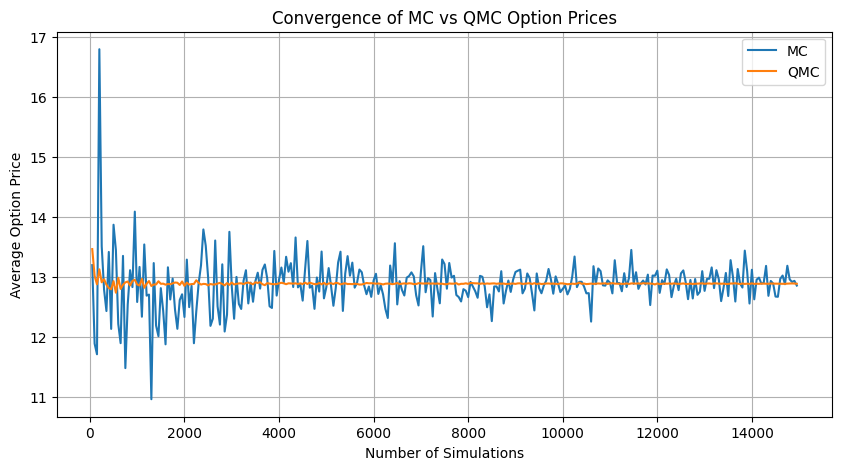

12.82158139269142


In [60]:


# BS parameters
r = 0.02      
sigma = 0.30  
x = 100       
T = 1         
K_vals = np.arange(95, 106, 1)  

# Monte Carlo
def mc_black_scholes(N):
    Z = np.random.randn(N)  
    X_T = x * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    call_prices = np.exp(-r * T) * np.maximum(X_T[:, None] - K_vals, 0)
    return call_prices

#Quasi Monte Carlo
def qmc_black_scholes(N):
    sobol_gen = Sobol(1, scramble=True)
    U = sobol_gen.random(N)[:, 0] 
    Z = stats.norm.ppf(U)
    X_T = x * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    call_prices = np.exp(-r * T) * np.maximum(X_T[:, None] - K_vals, 0)
    return call_prices

# Plot avg pricer over nb. simulations
n_values = list(range(50, 15000, 50))
mc_prices = []
qmc_prices = []

for N in n_values:
    mc_prices.append(mc_black_scholes(N).mean())
    qmc_prices.append(qmc_black_scholes(N).mean())

plt.figure(figsize=(10, 5))
plt.plot(n_values, mc_prices, '', label='MC')
plt.plot(n_values, qmc_prices, '', label='QMC')
plt.xlabel("Number of Simulations")
plt.ylabel("Average Option Price")
plt.legend()
plt.title("Convergence of MC vs QMC Option Prices")
plt.grid()
plt.show()
# ---- Black-Scholes Analytical Price ---- #
def black_scholes_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    return call_price
analytical_avg_price = black_scholes_price(x, K_vals.mean(), T, r, sigma)
print(analytical_avg_price)  # Analytical price



From this plot, we observe that the QMC simulation converges more quickly to the average call option price compared to the standard Monte Carlo (MC) simulation, which corresponds to the analytical Black-Scholes price. Furthermore, the MC simulation exhibits higher variance and greater instability throughout the entire simulation.

To further compare the two methods, we analyze the variance of the option price across different strike prices, highlighting the differences in the stability and efficiency of QMC vs. MC.

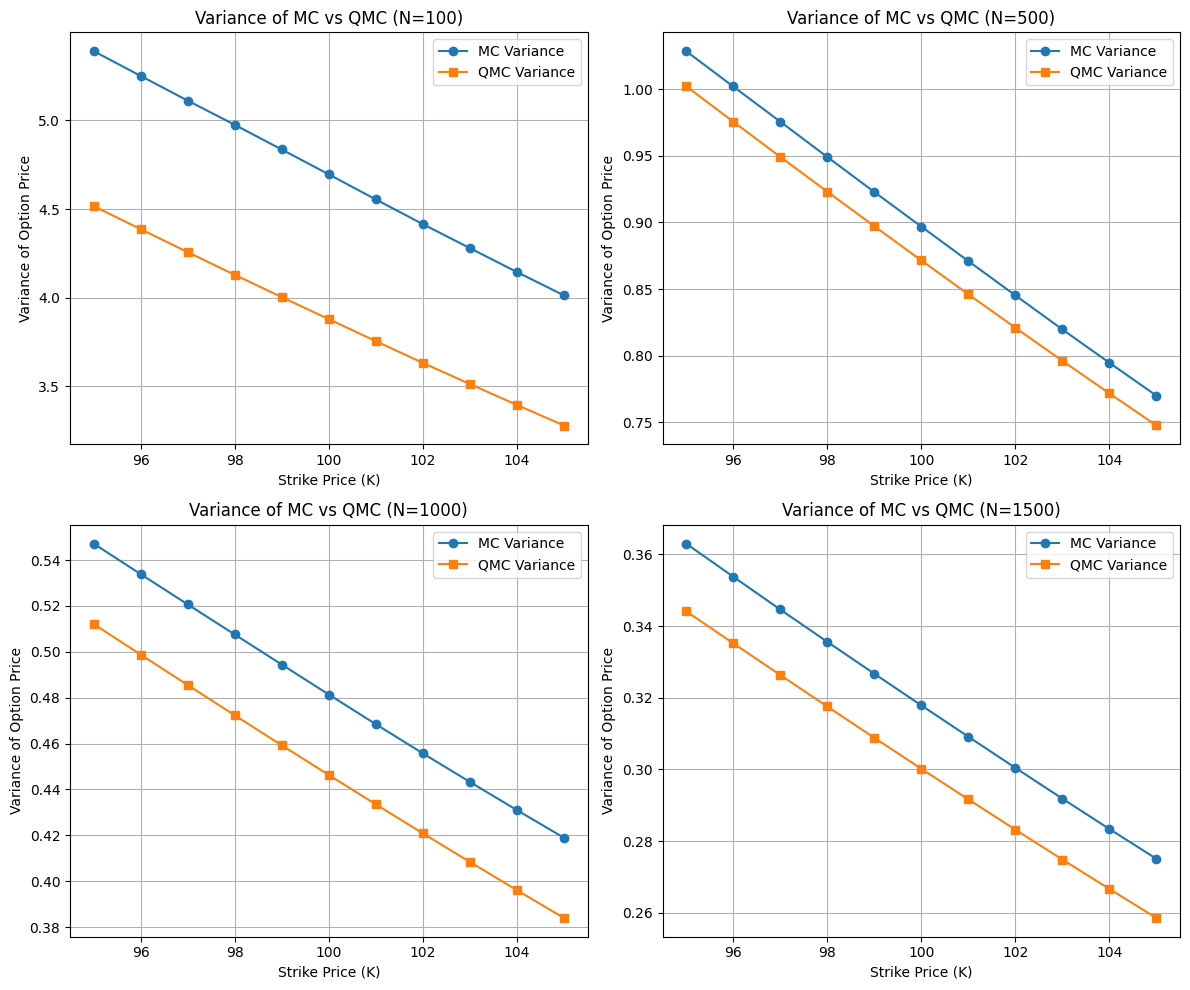

In [ ]:
discount_factor = np.exp(-r * T)
mc_prices = mc_black_scholes(N)
qmc_prices = qmc_black_scholes(N)

N=1500
mc_variance = (discount_factor * mc_prices).var(axis=0) / N
qmc_variance = (discount_factor * qmc_prices).var(axis=0) / N

N_values = [100, 500, 1000, 1500]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

discount_factor = np.exp(-r * T)

for i, N in enumerate(N_values):
    mc_prices = mc_black_scholes(N)
    qmc_prices = qmc_black_scholes(N)
    
    mc_variance = (discount_factor * mc_prices).var(axis=0) / N
    qmc_variance = (discount_factor * qmc_prices).var(axis=0) / N
    
    ax = axes[i]
    ax.plot(K_vals, mc_variance, 'o-', label='MC Variance')
    ax.plot(K_vals, qmc_variance, 's-', label='QMC Variance')
    ax.set_xlabel("Strike Price (K)")
    ax.set_ylabel("Variance of Option Price")
    ax.set_title(f"Variance of MC vs QMC (N={N})")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


As observed in the first plot, QMC generally exhibits lower variance than standard MC across all strike prices considered. However, it is important to note that these variance plots can fluctuate significantly across different simulations, and should therefore be interpreted with caution.

For a more reliable overall comparison of the two methods, the first plot provides the clearest representation of their relative performance.

We now implement the discrete time Euler scheme** with step $ \frac{T}{n} $ is defined by:

$$
\bar{X}_{t_{k+1}^n} = \bar{X}_{t_k^n} + \frac{T}{n} b(t_k^n, \bar{X}_{t_k^n}) + \sigma(t_k^n, \bar{X}_{t_k^n}) \sqrt{\frac{T}{n}} Z_{k+1}^n, \quad \bar{X}_0 = X_0, for  k = 0, \dots, n-1,
$$

where 

$$
t_k^n = \frac{kT}{n}, \quad k = 0, \dots, n
$$

and 

$$
(Z_k^n)_{1 \leq k \leq n}
$$

denotes a sequence of i.i.d. $ \mathcal{N}(0; I_q) $-distributed random vectors given by:

$$
Z_k^n := \sqrt{\frac{n}{T}} \left( W_{t_k^n} - W_{t_{k-1}^n} \right), \quad k = 1, \dots, n.
$$
And calculate the Black Scholes all option price when considering the step sizes with $n=10, 20, 50, 100$, using the dynamics:
$$dX_t^x=X_t^x(rdt+\sigma dW_t)$$
(note in the code $\frac{T}{m}$ is the stepsize not to confuse with the number of simulations $N$)

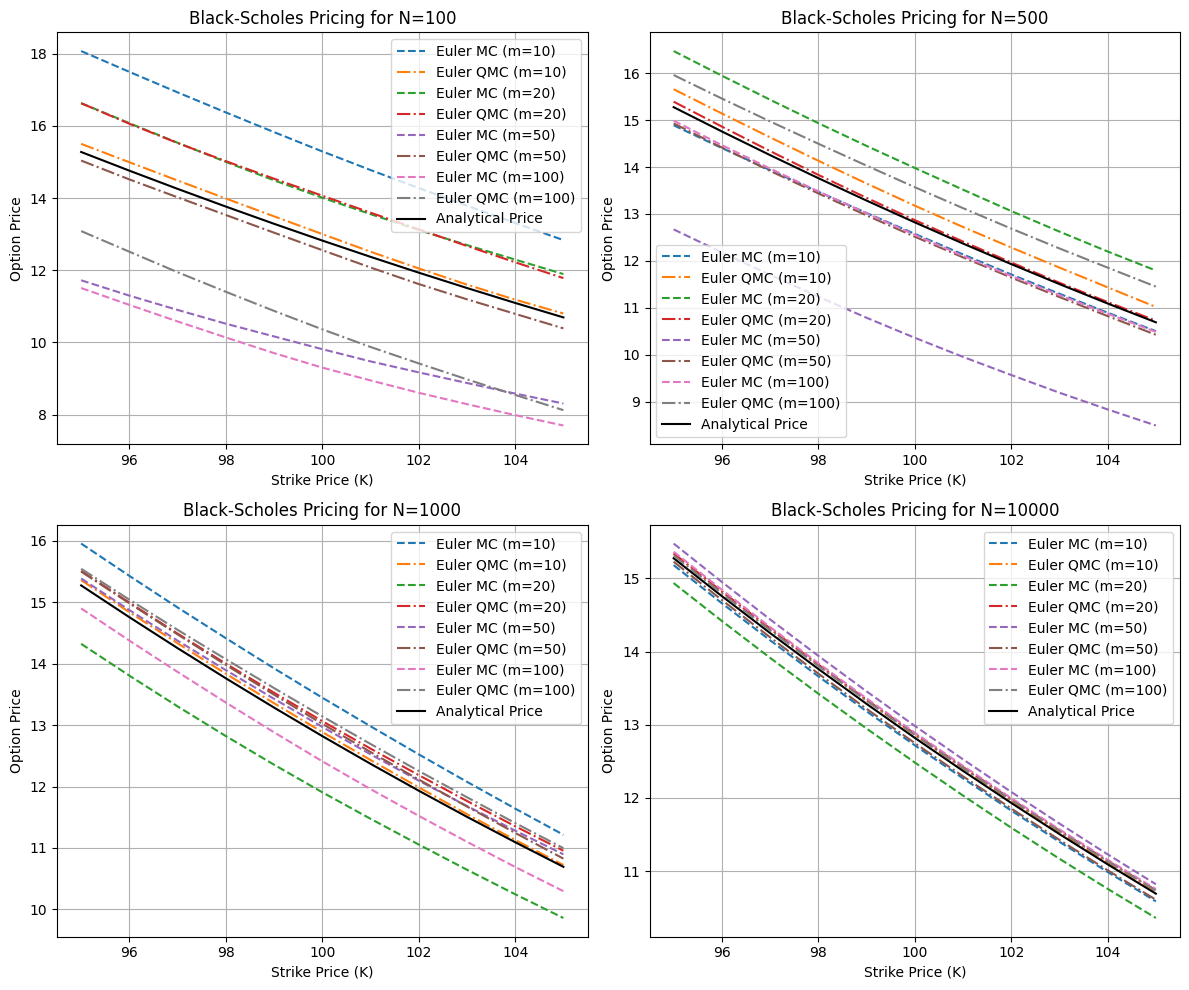

In [ ]:

K_vals = np.arange(95, 106, 1) 

#Regular Euler scheme
def euler_black_scholes(N, m):
    dt = T / m  
    X = np.full(N, x)  
    
    for _ in range(m):
        dW = np.sqrt(dt) * np.random.randn(N)  
        X = X + r * X * dt + sigma * X * dW
    
    call_prices = np.exp(-r * T) * np.maximum(X[:, None] - K_vals, 0)
    return call_prices

# Analytical prices
analytical_prices = np.array([black_scholes_price(x, K, T, r, sigma) for K in K_vals])

# QMC Euler scheme
def qmc_euler_black_scholes(N, m):
    sobol_gen = Sobol(m, scramble=True)  
    U = sobol_gen.random(N)  
    Z = stats.norm.ppf(U)  
    
    dt = T / m  
    X = np.full(N, x)  
    
    for i in range(m):  
        dW = np.sqrt(dt) * Z[:, i]  
        X = X + r * X * dt + sigma * X * dW
    
    call_prices_qmc = np.exp(-r * T) * np.maximum(X[:, None] - K_vals, 0)
    return call_prices_qmc

n_values = [100, 500, 1000, 10000]
m_values = [10, 20, 50, 100]

euler_prices = {N: {} for N in n_values}
euler_prices_qmc = {N: {} for N in n_values}

for N in n_values:
    for m in m_values:
        euler_prices[N][m] = euler_black_scholes(N, m).mean(axis=0)
        euler_prices_qmc[N][m] = qmc_euler_black_scholes(N, m).mean(axis=0)


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, N in enumerate(n_values):
    ax = axes[i]
    for m in m_values:
        ax.plot(K_vals, euler_prices[N][m], '--', label=f'Euler MC (m={m})')
        ax.plot(K_vals, euler_prices_qmc[N][m], '-.', label=f'Euler QMC (m={m})')
    ax.plot(K_vals, analytical_prices, 'k-', label='Analytical Price')
    ax.set_xlabel("Strike Price (K)")
    ax.set_ylabel("Option Price")
    ax.set_title(f"Black-Scholes Pricing for N={N}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


From these plots, we observe that the QMC Euler scheme consistently tends to be closer to the analytical Black-Scholes price across all strike prices. Most noticeably for smaller m
The standard MC Euler scheme exhibits greater deviations due to higher variance.
In addition when N increases, both methods converge toward the analytical solution, but QMC achieves this convergence faster.
QMC allows us to achieve the same level of accuracy with fewer simulations, making it a more cost efficient alternative to standard MC.